# An Introduction to CPPI

Constant Proportion Portfolio Insuruance or CPPI for short is a specific form of insurance strategy. CPPI strategies were introduced by Black and Jones in 1987. The CPPI procedure allows you to generate convex option-like payoffs without using options. CPPI dynamically allocates total assests to a risky asset and a safe asset, this allows for simultaneous downside protection and upside potential. 

The principles behind CPPI are actually very simple. You are going to allocate to a risky asset in a multiple of m of the difference beween your asset value and a given floor. Asset value minus the floor value is defined as your 'cushion'. CPPI says that you should allocate to the risky asset in a multiple of that cushion. So, even when the cushion goes down you are reducing the risky asset allocation. This keeps you safe if you happen to keep on decreasing in cushion value, the risky asset is allocated to less.

### Downside Protection

In practice you may not be able to trade continously every day for example, perhaps you are training montly or quarterly, there could be a scenario where between two trading dates the loss is so large that you actually breach the floor value before actually trading. You didn't have time to correct allocation. The risk of breaching the floor because of discrete trading in the CPPI strategy is known as gap risk. Gap risk will materialise if and only if the loss on the risky portfolio relative to the safe portfolio exceeds 1/M within the trading interval. Due to this it is recommended that you actually calibrate the multipler m as a function of the potential loss withing the trading interval.

### Introducing Max Drawdown Constraints

Now, we are going to introduce a specific version of the strategy where we're going to try and protect a floor which is going to be a maximum drawdown floor. The goal of this strategy is to maintain the maximum drawdown below a certain pressure level.

Example max drawdown constraint: $V_t > \alpha M_t,$ where: $V_t$ is the value of the portfolio at time $t$, $M_t$ is the maximum value of the portfolio between time 0 and time $t$ and $1 - \alpha$ is the maximum acceptable drawdown.

### CPPI with Performance Cap

Protecting downside has an opportunity cost. Now, by giving up on some of the upside above and beyond the cap (threshold) then you can actually get an opportunity gain which can cover some or all of the opportunity cost from downside protection. In other word, we are suggesting the truncate the asset return distribution by giving up on the downside as we always do but also giving up on the upside. In practice, we do this by defining threshold levels:

$$ F_t \leq A_t \leq T_t \Rightarrow E_t = m\left(A_t - F_t \right),$$
$$T_t \leq A_t \leq C_t \Rightarrow E_t = m\left(C_t - A_t \right),$$

where $F$ is the floor value, $T$ is the threshold value, $C$ is the cap value, $A$ is the asset value and $m$ is the multiplier. This allows our portfolio to reduce risk and slow down as we reach the floor or cap.

### Performance Cap and the Threshold Process

The threshold value is obtained by imposing the "Smooth-pasting" condition where we look at behaviour of the asset at or near the threshold value,

$$A_t = T_t \Rightarrow E_t = m\left(T_t - F_t \right) = m\left(C_t - T_t\right).$$

If we solve for the threshold value we find that it is actually given by the average of the floor and ceiling value:

$$T_t = \frac{F_t + C_t}{2}.$$

# Lab Session - CPPI and Drawdown Constraints

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [3]:
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [4]:
risky_r = ind_return.loc['2000':][['Steel', 'Fin', 'Beer']]
risky_r.shape

(228, 3)

In [5]:
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.shape

(228, 3)

In [6]:
safe_r.loc[:] = 0.03/12
start = 1000
floor = 0.80

1. Cushion (Asset value - Floor value)
2. Compute an allocation to safe and risky assets -> m * risk budget
3. Recompute the asset value based on the returns

In [21]:
def c1(r):
    return (1+r).prod() - 1

def c2(r):
    return np.expm1(np.log1p(r).sum())

In [22]:
c1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [23]:
c2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [24]:
%timeit c1(risky_r)

137 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
%timeit c2(risky_r)

139 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Back to CPPI

In [30]:
dates = risky_r.index
n_steps = len(dates)
account_value = start 
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    # update account value for this time step
    account_value = (risky_alloc * (1 + risky_r.iloc[step])) + (safe_alloc * (1+ safe_r.iloc[step]))
    # save values to look at history
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value


In [31]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


<AxesSubplot:>

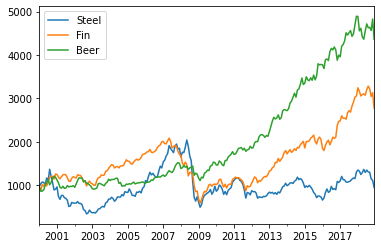

In [35]:
risky_wealth = start * (1 + risky_r).cumprod()
risky_wealth.plot()

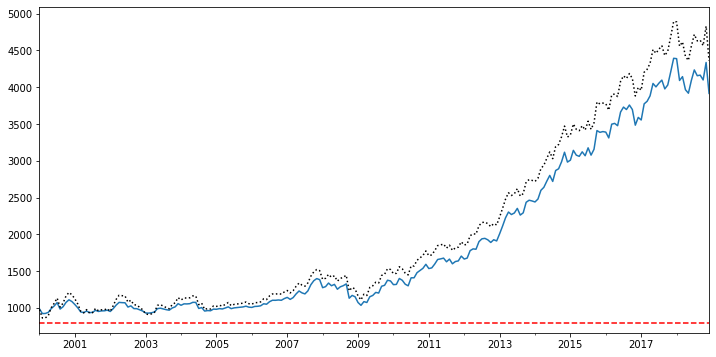

In [41]:
ax = account_history['Beer'].plot(figsize = (12, 6))
risky_wealth['Beer'].plot(ax = ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

<AxesSubplot:>

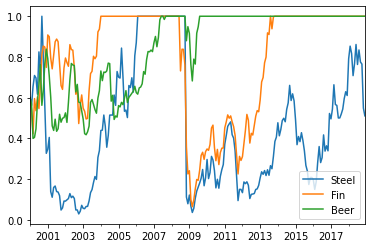

In [42]:
risky_w_history.plot()

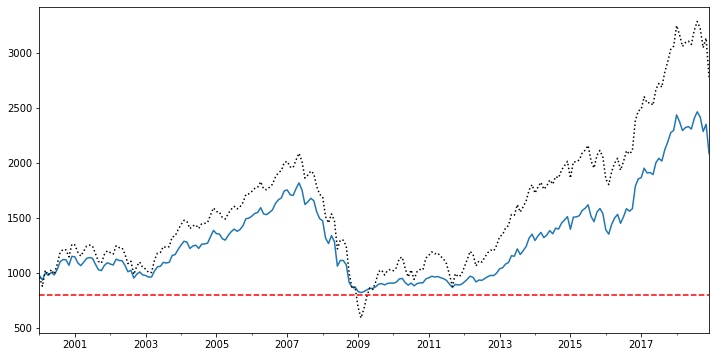

In [43]:
ind = 'Fin'
ax = account_history[ind].plot(figsize = (12, 6))
risky_wealth[ind].plot(ax = ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

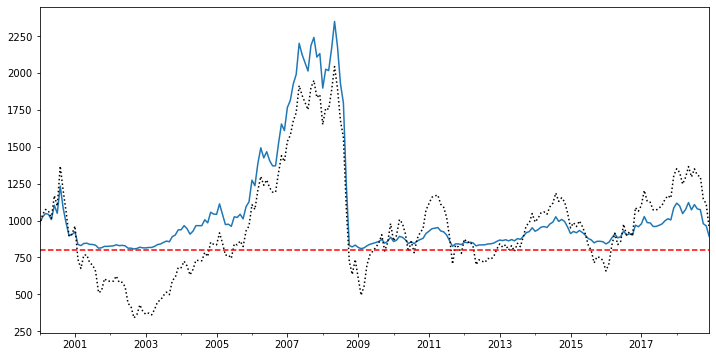

In [44]:
ind = 'Steel'
ax = account_history[ind].plot(figsize = (12, 6))
risky_wealth[ind].plot(ax = ax, style = 'k:')
ax.axhline(y = floor_value, color = 'r', linestyle = '--')

In [49]:
erk.summary_stats(risky_r)

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150499,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091818,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063382,0.091442,0.354314,-0.271368


In [50]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.099498,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.066812,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.053482,0.074908,0.383772,-0.259582


<AxesSubplot:>

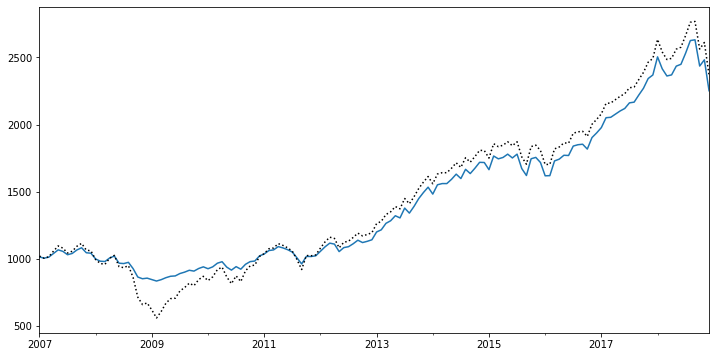

In [53]:
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize = (12, 6), legend = False)
btr['Risky Wealth'].plot(ax = ax, style = 'k:', legend = False)

In [54]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.07247,0.096315,0.280618,-0.499943


In [55]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.046054,0.062953,0.382052,-0.229683


## Drawdown Constraint

In [57]:
btr = erk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown_constraint = 0.25)

<AxesSubplot:>

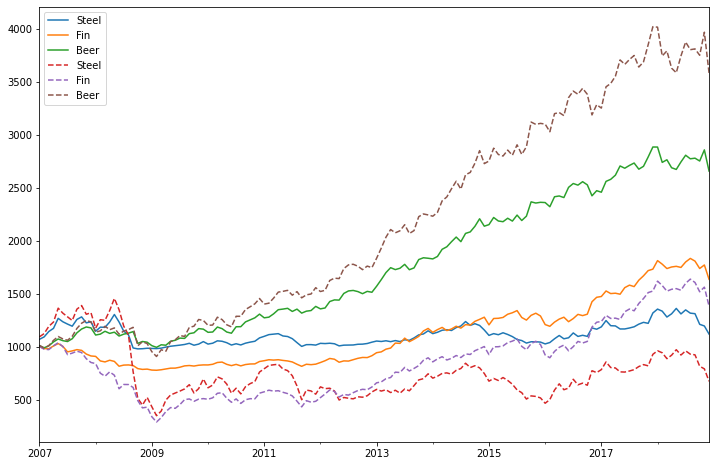

In [59]:
ax = btr['Wealth'].plot(figsize = (12, 8))
btr['Risky Wealth'].plot(ax = ax, style = '--')

In [60]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152988,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.106852,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.057119,0.077388,0.620132,-0.271368


In [61]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047575,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038458,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.038454,0.051189,0.613413,-0.161186
